# Importing Libraries

In [1]:
  >>> import nltk
  >>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucaspicot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Spliting Data

In [3]:

df = pd.read_csv('tokenized_df.csv')

Splitting the data into 2 parts - training and testing data

In [4]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.label,random_state = 0)

In [5]:
max_features = 10000
maxlen = 300

# Tokenizing Text

Tokenizing Text -> Representing each word by a number

Mapping of orginal word to number is preserved in word_index property of tokenizer

Tokenized applies basic processing like changing it to lower case, explicitely setting that as False

Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones

In [6]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [7]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

# Introduction to GloVe

GloVe method is built on an important idea, You can derive semantic relationships between words from the co-occurrence matrix. Given a corpus having V words, the co-occurrence matrix X will be a V x V matrix, where the i th row and j th column of X, X_ij denotes how many times word i has co-occurred with word j. An example co-occurrence matrix might look as follows.


Source Credits - https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010

In [8]:
EMBEDDING_FILE = 'glove.twitter.27B.25d.txt'

In [9]:
EMBEDDING_FILE

'glove.twitter.27B.25d.txt'

In [10]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [11]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/Users/lucaspicot/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


# Training Model

Some Model Parameters

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
batch_size = 256
epochs = 30
embed_size = 25

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [15]:
#Defining Neural Network
model = Sequential()

#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=True))

#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

2022-09-09 11:24:43.214982: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 25)           250000    
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          78848     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 380,369
Trainable params: 380,369
Non-trainable params: 0
__________________________________________________

In [17]:
history = model.fit(x_train, y_train, batch_size = batch_size, validation_split = 0.2 , epochs = epochs )


2022-09-09 11:24:43.569622: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
219/219 [==============================] - 355s 2s/step - loss: 0.6911 - accuracy: 0.5159 - val_loss: 0.6698 - val_accuracy: 0.5506
Epoch 2/30
219/219 [==============================] - 318s 1s/step - loss: 0.6618 - accuracy: 0.5500 - val_loss: 0.6573 - val_accuracy: 0.5543
Epoch 3/30
219/219 [==============================] - 336s 2s/step - loss: 0.6558 - accuracy: 0.5488 - val_loss: 0.6546 - val_accuracy: 0.5541
Epoch 4/30
219/219 [==============================] - 324s 1s/step - loss: 0.6508 - accuracy: 0.5505 - val_loss: 0.6539 - val_accuracy: 0.5423
Epoch 5/30
219/219 [==============================] - 346s 2s/step - loss: 0.6450 - accuracy: 0.5579 - val_loss: 0.6547 - val_accuracy: 0.5501
Epoch 6/30
219/219 [==============================] - 381s 2s/step - loss: 0.6405 - accuracy: 0.5645 - val_loss: 0.6470 - val_accuracy: 0.5461
Epoch 7/30
219/219 [==============================] - 355s 2s/step - loss: 0.6357 - accuracy: 0.5690 - val_loss: 0.6457 - val_accuracy: 0.5393

# Analyse after training the Model

In [18]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

2185/2185 [==============================] - 170s 78ms/step - loss: 0.6051 - accuracy: 0.6060
Accuracy of the model on Training Data is -  60.600125789642334 %
729/729 [==============================] - 52s 71ms/step - loss: 0.7803 - accuracy: 0.5090
Accuracy of the model on Testing Data is -  50.903159379959106 %


ValueError: x and y must have same first dimension, but have shapes (2,) and (30,)

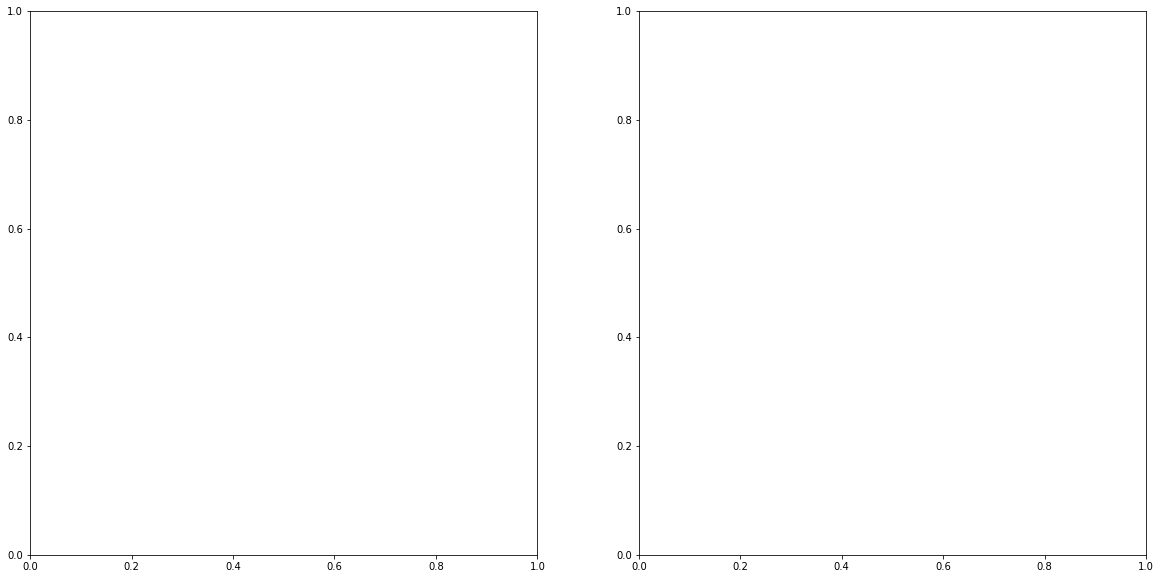

In [20]:
epochs = [i for i in range(2)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [21]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)


In [ ]:
y_pred[:10]

In [ ]:
print(classification_report(y_test, y_pred, target_names = ['Fake','Not Fake']))

In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm

In [ ]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
accuracy_score(y_test,y_pred)